In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.constants import c, k_B, M_sun, G, m_p, sigma_sb, m_p
import astropy.units as u
from scipy.sparse import csr_matrix
from scipy.optimize import fsolve
import numpy as np
import numba
import sys

sys.path.append('../Numerical_methods')
from bachelor_funcs import Σ_initial
from matrix_calculator import A_matrix

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)

In [2]:
N = 300
r_in = 0.01 # AU
r_out = 1e4 # AU 
r = np.logspace(np.log(r_in), np.log(r_out), N, base = np.exp(1))
r_au = r * u.au
r_log = np.log(r)
Δr_log = r_log[1] - r_log[0]

### Temperature bith viscous heating and stellar irradiation
$$T^4 = T_{vis}^4 + T_{req}^4$$

### Temperature from irradition
$$T_{1au}=280K\quad p=-1/2$$
$$T_{req}=T_{1au}\left(\frac{r}{1au}\right)^p$$

Text(0.5, 0, 'Distance from star [AU]')

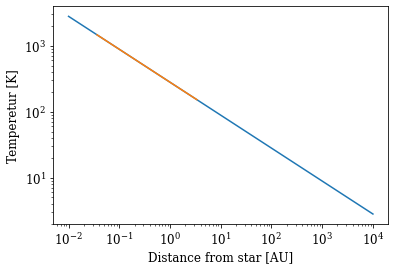

In [3]:
T_1au = 280 * u.K
p = -1/2

T_req = T_1au * (r)**p
plt.loglog(r, T_req)
plt.loglog(r[np.where((T_req >= 150 * u.K) & (T_req <= 1500 * u.K))], T_req[np.where((T_req >= 150 * u.K) & (T_req <= 1500 * u.K))])
plt.ylabel('Temperetur [K]')
plt.xlabel('Distance from star [AU]')

In [4]:
D1_log = A_matrix(4, 1, N) / Δr_log
sD1_log = csr_matrix(D1_log.copy())

Text(0.5, 0, 'Distance from star [AU]')

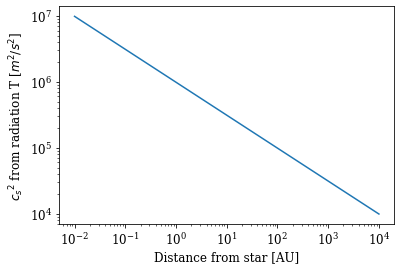

In [5]:
def c_s2(T):
    μ = 2.34
    return ((k_B * T) / (μ * m_p)).decompose()

plt.loglog(r, c_s2(T_req)) 
c_s2(T_req).unit, T_req.unit
plt.ylabel('${c_s}^2$ from radiation T [$m^2/s^2$]')
plt.xlabel('Distance from star [AU]')

### Temperature at midplane
$$T_{vis}^4 = \frac{1}{2\sigma_{SB}}\left(\frac{3}{8}\tau_R+\frac{1}{3\tau_P}\right)F_{rad}$$
$$\tau_R=\kappa_R\Sigma/2$$
### $\kappa_R:$
$$\kappa_R = 4.5(T/150K)^2\;cm^2g^{-1}\quad T<150K$$
$$\kappa_R = 4.5\;cm^2g^{-1}\quad 150K \leq T \leq1500K$$
$$\kappa_R = 0\;cm^2g^{-1}\quad 1500K<T$$

$$\tau_P = max(2.4\tau_R,\;0.5)$$

$$F_{rad} = max\left(-\frac{1}{r}\partial_r r^2 \Sigma \Omega α_{rφ} c_s^2,\;0\right)$$
$$[r^2 \Sigma \Omega α_{rφ} c_s^2] = \frac{m^2kg}{s^3}\quad\Rightarrow\quad [F_{rad}]=\frac{kg}{s^3}$$


In [6]:
Ω = (np.sqrt((G * M_sun) / r_au**3)).decompose()
print(Ω.unit) 
print(sigma_sb.decompose())

1 / s
5.6703744191844314e-08 kg / (K4 s3)


<Quantity [] kg / s3>

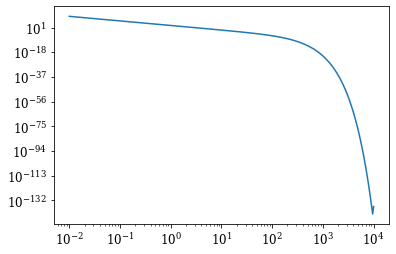

In [7]:
α_rφ = 8e-3
func_to_der = r_au**2 * Σ_initial(r_au) * Ω * α_rφ * c_s2(T_req)
F_rad = (-(r_au**(-2)) * (sD1_log @ func_to_der) * func_to_der.unit).decompose()

plt.loglog(r, F_rad)
F_rad[F_rad < 0]

In [8]:
test = np.array([3])
type(test) == np.ndarray
type(T_req)

astropy.units.quantity.Quantity

In [9]:
def tau_R(T, Σ):
    if type(T) != np.ndarray:
        T = (T.value).copy()
    else:
        T = T.copy()
    T[T < 150] = 4.5 * (T[T < 150] / 150)**2 

    T[np.where((T >= 150) & (T <= 1500))] = 4.5 

    T[T > 1500] = 0 

    return T * (Σ.to('g/cm2')).value / 2


def tau_P(τ_R):
    τ_R_new = τ_R.copy()
    τ_R_new[2.4 * τ_R_new <= 0.5] = 0.5
    τ_R_new[2.4 * τ_R_new >= 0.5] = 2.4 * τ_R_new
    return τ_R_new

In [10]:
def F_rad_func(Σ, cs2):
    func_to_der = r_au**2 * Σ * Ω * α_rφ * cs2
    F_rad = (-(r_au**(-2)) * (sD1_log @ func_to_der) * func_to_der.unit).decompose()
    F_rad_nounit = F_rad.value
    F_rad_nounit[F_rad_nounit <= 0] = 0
    return F_rad

In [11]:
F_rad_func(Σ_initial(r_au), c_s2(T_req))

<Quantity [4.01091987e+009, 3.41498309e+009, 2.90503959e+009,
           2.47124292e+009, 2.10222262e+009, 1.78830605e+009,
           1.52126494e+009, 1.29409969e+009, 1.10085588e+009,
           9.36468234e+008, 7.96627836e+008, 6.77669191e+008,
           5.76474146e+008, 4.90390160e+008, 4.17160782e+008,
           3.54866498e+008, 3.01874426e+008, 2.56795511e+008,
           2.18448118e+008, 1.85827057e+008, 1.58077240e+008,
           1.34471261e+008, 1.14390337e+008, 9.73080828e+007,
           8.27767162e+007, 7.04153202e+007, 5.98998583e+007,
           5.09546812e+007, 4.33453010e+007, 3.68722449e+007,
           3.13658270e+007, 2.66816997e+007, 2.26970706e+007,
           1.93074835e+007, 1.64240803e+007, 1.39712721e+007,
           1.18847574e+007, 1.01098368e+007, 8.59997909e+006,
           7.31560162e+006, 6.22303255e+006, 5.29362826e+006,
           4.50302252e+006, 3.83048774e+006, 3.25839161e+006,
           2.77173489e+006, 2.35775823e+006, 2.00560767e+006,
        

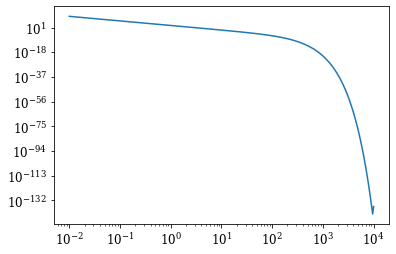

In [12]:
plt.loglog(r, F_rad_func(Σ_initial(r_au), c_s2(T_req)))

In [13]:
def T_vis(T, Σ):
    return ((0.5 * sigma_sb**(-1) * (3/8 * tau_R(T, Σ) + tau_P(tau_R(T, Σ))) * F_rad_func(Σ, c_s2(T)))**(0.25)).decompose()

In [19]:
T_vis(T_req, Σ_initial(r_au))

<Quantity [1.43531054e+04, 1.37873886e+04, 1.32410642e+04, 1.27163871e+04,
           1.22124994e+04, 1.17285774e+04, 1.12638301e+04, 1.08174977e+04,
           1.03888505e+04, 9.97718766e+03, 9.58183632e+03, 9.20215012e+03,
           8.83750835e+03, 8.48731489e+03, 8.15099725e+03, 7.82800562e+03,
           7.51781197e+03, 7.21990919e+03, 6.93381029e+03, 6.65904755e+03,
           6.39517178e+03, 6.14175160e+03, 5.89837273e+03, 5.66463730e+03,
           5.44016318e+03, 5.22458342e+03, 5.01754559e+03, 4.81871122e+03,
           2.76194082e+05, 2.60688836e+05, 2.46053816e+05, 2.32240182e+05,
           2.19201837e+05, 2.06895271e+05, 1.95279415e+05, 1.84315504e+05,
           1.73966952e+05, 1.64199222e+05, 1.54979717e+05, 1.46277671e+05,
           1.38064042e+05, 1.30311420e+05, 1.22993932e+05, 1.16087156e+05,
           1.09568044e+05, 1.03414838e+05, 9.76070033e+04, 9.21251561e+04,
           8.69510016e+04, 8.20672711e+04, 7.74576653e+04, 7.31067996e+04,
           6.90001528e+04

In [20]:
T_req

<Quantity [2800.        , 2736.05350835, 2673.56742878, 2612.50840833,
           2552.8438558 , 2494.54192426, 2437.57149415, 2381.90215658,
           2327.50419717, 2274.34858013, 2222.40693282, 2171.65153055,
           2122.05528182, 2073.59171383, 2026.2349584 , 1979.9597381 ,
           1934.7413528 , 1890.55566646, 1847.37909427, 1805.18859005,
           1763.96163395, 1723.67622042, 1684.31084648, 1645.84450024,
           1608.25664967, 1571.52723167, 1535.63664131, 1500.56572144,
           1466.29575238, 1432.80844199, 1400.0859159 , 1368.11070792,
           1336.8657508 , 1306.33436703, 1276.50025999, 1247.34750528,
           1218.86054212, 1191.02416517, 1163.8235163 , 1137.24407675,
           1111.2716593 , 1085.89240077, 1061.09275458, 1036.85948352,
           1013.1796527 ,  990.04062263,  967.43004249,  945.33584351,
            923.74623258,  902.64968588,  882.03494281,  861.89099992,
            842.20710505,  822.97275162,  804.17767298,  785.81183697,
      

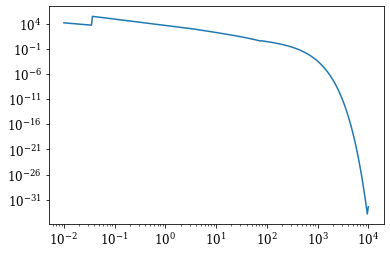

In [14]:
plt.loglog(r, T_vis(T_req, Σ_initial(r_au)))

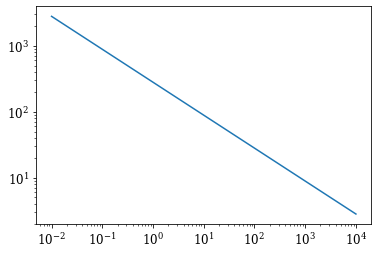

In [15]:
plt.loglog(r, T_req)

In [16]:
res = fsolve(lambda T: T_vis(T, Σ_initial(r_au))**4 + T_req**4 - T**4, x0 = T_req)

UnitConversionError: Can only apply 'add' function to quantities with compatible dimensions